## 第一部分：描述分析
    这部分先预览梳理下数据，做一些基本的描述性统计，画图比较下影响商品销量和回购的几个因素

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os,sys
from itertools import combinations, groupby
from collections import Counter
color = sns.color_palette()

### 数据集内容：
    一套描述不同时段顾客购买行为的关系数据集
    先把数据集导入进来看下基本信息，进行数据清洗

In [2]:
from subprocess import check_output
print(check_output(["ls","../market_sells_orders/input"]).decode("utf8"))

aisles.csv
departments.csv
order_products__prior.csv
order_products__train.csv
orders.csv
products.csv



In [3]:
df_order_products = pd.read_csv('../market_sells_orders/input/order_products__prior.csv')
print('order_products contains %s orders with columns:'%len(df_order_products))
print('            '+', '.join(df_order_products.columns.values))
df_orders = pd.read_csv('../market_sells_orders/input/orders.csv')
df_orders = df_orders[df_orders['eval_set']=='prior']
df_orders.drop(columns=['eval_set'],inplace=True)
print('orders contains %s orders with columns:'%len(df_orders))
print('            '+', '.join(df_orders.columns.values))
df_aisles = pd.read_csv('../market_sells_orders/input/aisles.csv')
print('aisles contains %s aisles with columns:'%len(df_aisles))
print('            '+', '.join(df_aisles.columns.values))
df_department = pd.read_csv('../market_sells_orders/input/departments.csv')
print('department contains %s departments with columns:'%len(df_department))
print('            '+', '.join(df_department.columns.values))
df_products = pd.read_csv('../market_sells_orders/input/products.csv')
print('products contains %s products with columns:'%len(df_products))
print('            '+', '.join(df_products.columns.values))

order_products contains 32434489 orders with columns:
            order_id, product_id, add_to_cart_order, reordered
orders contains 3214874 orders with columns:
            order_id, user_id, order_number, order_dow, order_hour_of_day, days_since_prior_order
aisles contains 134 aisles with columns:
            aisle_id, aisle
department contains 21 departments with columns:
            department_id, department
products contains 49688 products with columns:
            product_id, product_name, aisle_id, department_id


载入四组数据，存放在dataframe中：
* order_products 是3千多万条不同商品在不同订单下的记录，有商品id、订单id、加入购物车的顺序、以及是否会回购四个属性
* orders 记录了3百多万个订单信息，有订单id、用户id、是该用户的第几个订单以及下订单是星期几、几点、还有用户距上一次下订单过了几天这六个属性
* aisles department products主要记录了商品的名称、所属货架、所属部门等基本信息

下面来预览下主要的两组记录订单的数据，看下是否有残缺值

In [4]:
df_order_products.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [5]:
df_order_products.isnull().any()

order_id             False
product_id           False
add_to_cart_order    False
reordered            False
dtype: bool

In [6]:
df_orders.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,1,2,8,NaN
1,2398795,1,2,3,7,15.0
2,473747,1,3,3,12,21.0
3,2254736,1,4,4,7,29.0
4,431534,1,5,4,15,28.0


In [7]:
df_orders.isnull().any()

order_id                  False
user_id                   False
order_number              False
order_dow                 False
order_hour_of_day         False
days_since_prior_order     True
dtype: bool

days_since_prior_order有null值，是第一次下订单的情况，没有异常

再来看下每用户的订单数，order_number是针对每个用户的订单编号，所以可以用其最大值统计每用户订单数。

users_total: 206209


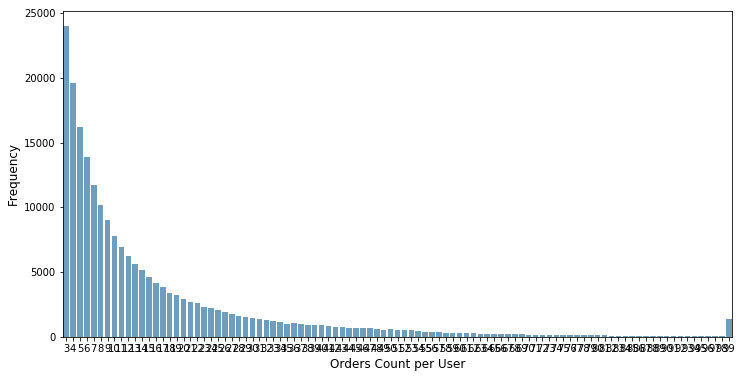

In [8]:
print('users_total: '+str(df_orders['user_id'].nunique()))
count_orders = df_orders.groupby('user_id')['order_number'].max().reset_index()
count_orders = count_orders['order_number'].value_counts()
plt.figure(figsize=(12,6))
sns.barplot(count_orders.index,count_orders.values,alpha=0.7,color=color[0])
plt.ylabel('Frequency', fontsize = 12)
plt.xlabel('Orders Count per User', fontsize = 12)
plt.show()

以上是数据的基本信息，每个用户大约有4～100条订单记录，大部分都小于10条

### 观测用户的购物周期模式
* 一周内不同日期的商品销量

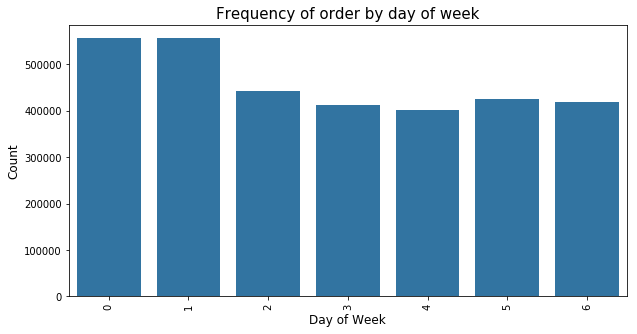

In [9]:
plt.figure(figsize=(10,5))
sns.countplot(x='order_dow',data=df_orders,color=color[0])
plt.ylabel('Count',fontsize=12)
plt.xlabel('Day of Week',fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by day of week",fontsize=15)
plt.show()

* 一天内不同时段的商品销量

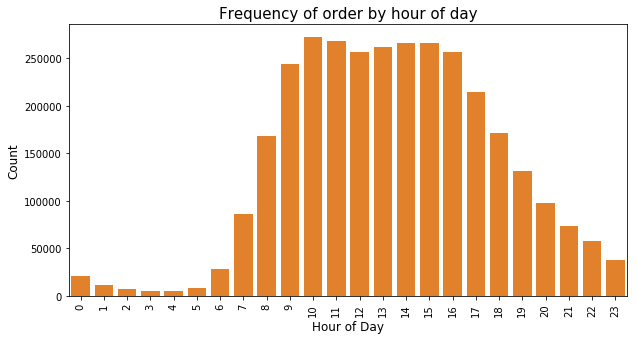

In [10]:
plt.figure(figsize=(10,5))
sns.countplot(x='order_hour_of_day',data=df_orders,color=color[1])
plt.ylabel('Count',fontsize=12)
plt.xlabel('Hour of Day',fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by hour of day",fontsize=15)
plt.show()

可见时段对销量的影响还比较大，周末的销量要明显高些，一天里9点到16点是购物高峰，结合起来画个热度图直观看下：

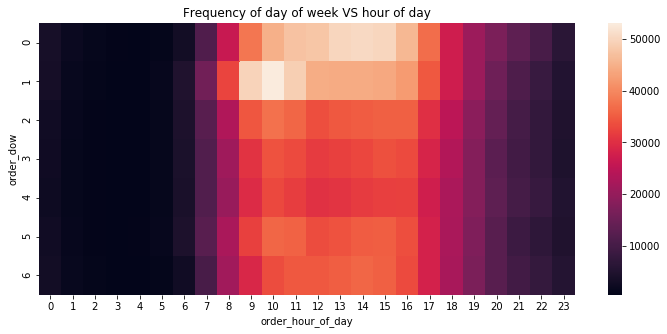

In [11]:
df_grouped = df_orders.groupby(["order_dow","order_hour_of_day"])["order_number"].count().reset_index()
df_grouped = df_grouped.pivot('order_dow','order_hour_of_day','order_number')
plt.figure(figsize=(12,5))
sns.heatmap(df_grouped)
plt.title("Frequency of day of week VS hour of day")
plt.show()

那么用户的购物频次呢，有没有什么周期性？可以通过查看与上次下单间隔的时间得出结论：

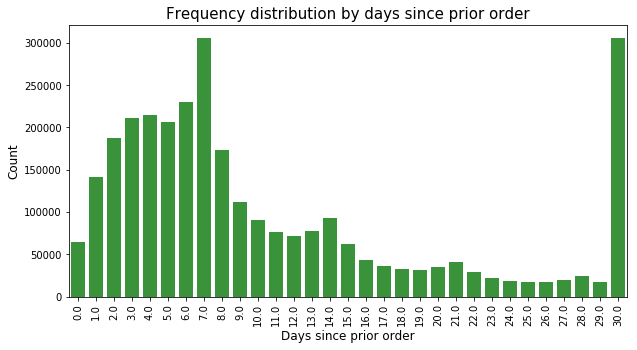

In [12]:
plt.figure(figsize=(10,5))
sns.countplot(x="days_since_prior_order",data=df_orders,color=color[2])
plt.ylabel('Count',fontsize=12)
plt.xlabel('Days since prior order',fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency distribution by days since prior order",fontsize=15)
plt.show()

观察图标，7天和30天是一个明显的高峰，有很多用户的购买模式是一周一次或一月一次，此外，每隔7天都有一个小高峰。

### 影响回购的因素
思考可能影响的因素有：
* 商品所属的aisle、department：观察下不同aisle不同department回购数量的比重
* 加入购物车的顺序
* 购买时段：比如周末可能补充日用，更可能日用
#### 首先来统计下不同商品被reorder的次数，并看下重购次数最多的前10名产品

In [13]:
reorder_count = df_order_products[['product_id','reordered']].groupby('product_id').sum().rename(columns={'reordered':'reorder_count'})
df_products_clean = df_products.merge(reorder_count,on='product_id').sort_values('reorder_count',ascending=False)
df_products_clean.head(10)

,product_id,product_name,aisle_id,department_id,reorder_count
24848,24852,Banana,24,4,398609
13172,13176,Bag of Organic Bananas,24,4,315913
21133,21137,Organic Strawberries,24,4,205845
21899,21903,Organic Baby Spinach,123,4,186884
47198,47209,Organic Hass Avocado,24,4,170131
47755,47766,Organic Avocado,24,4,134044
27839,27845,Organic Whole Milk,84,16,114510
47615,47626,Large Lemon,24,4,106255
27960,27966,Organic Raspberries,123,4,105409
16793,16797,Strawberries,24,4,99802


有机食品，尤其是水果霸占了前十名，香蕉好受欢迎。。。
#### 不同aisle回购的比例

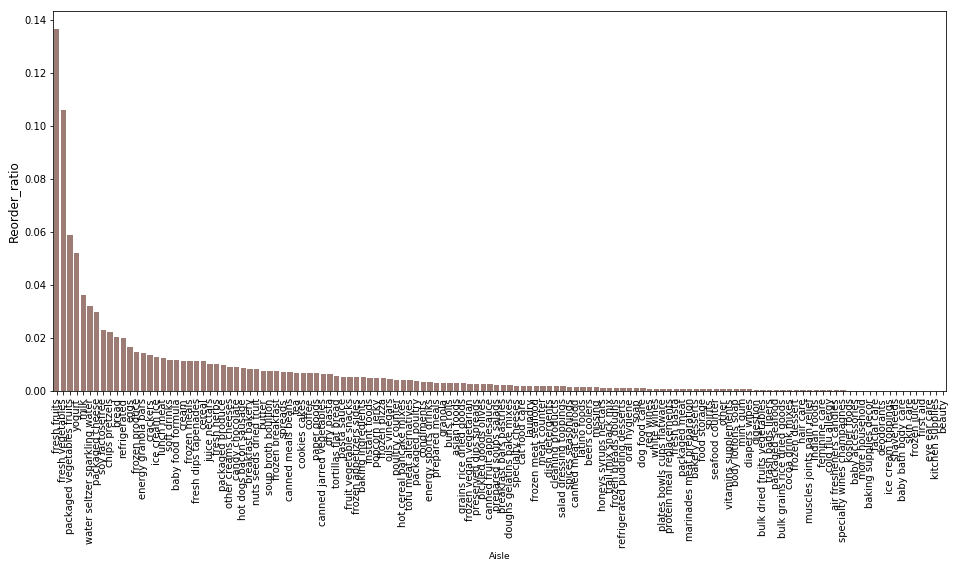

In [14]:
reorder_total = df_products_clean['reorder_count'].sum()
reorder_ratio_aisle = df_products_clean[['aisle_id','reorder_count']].groupby('aisle_id').sum().reset_index()
reorder_ratio_aisle = reorder_ratio_aisle.rename(columns={"reorder_count":'reorder_ratio'})
reorder_ratio_aisle['reorder_ratio'] = reorder_ratio_aisle['reorder_ratio']/reorder_total
df_aisle_reorder = df_aisles.merge(reorder_ratio_aisle,on='aisle_id').sort_values('reorder_ratio',ascending=False)

plt.figure(figsize=(16,7))
sns.barplot(df_aisle_reorder['aisle'],df_aisle_reorder['reorder_ratio'], alpha=0.8, color=color[5])
plt.ylabel('Reorder_ratio', fontsize=12)
plt.xlabel('Aisle', fontsize=9)
plt.xticks(rotation='vertical')
plt.show()

In [15]:
df_aisle_reorder.head(10)

,aisle_id,aisle,reorder_ratio
23,24,fresh fruits,0.136746
82,83,fresh vegetables,0.106249
122,123,packaged vegetables fruits,0.058933
119,120,yogurt,0.052127
83,84,milk,0.036403
114,115,water seltzer sparkling water,0.032101
20,21,packaged cheese,0.029978
90,91,soy lactosefree,0.023110
106,107,chips pretzels,0.022241
111,112,bread,0.020492


不出意外，蔬果占前三名，比例之和为30%
#### 不同department回购的比例

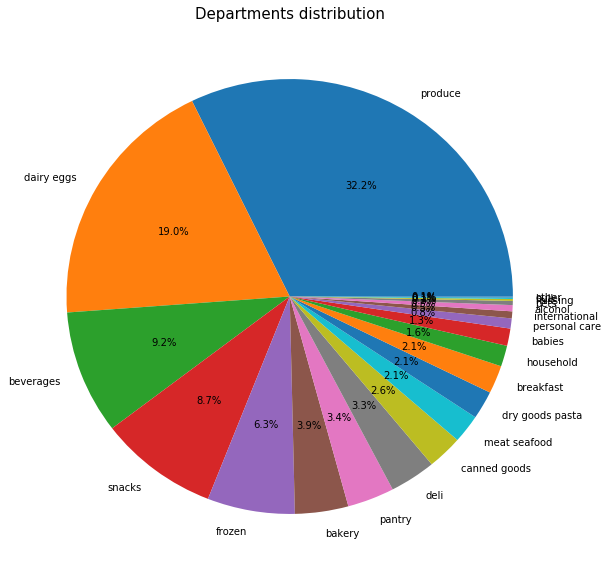

In [16]:
reorder_ratio_department = df_products_clean[['department_id','reorder_count']].groupby('department_id').sum().reset_index()
reorder_ratio_department = reorder_ratio_department.rename(columns={"reorder_count":'reorder_ratio'})
reorder_ratio_department['reorder_ratio'] = reorder_ratio_department['reorder_ratio']/reorder_total
df_department_reorder = df_department.merge(reorder_ratio_department,on='department_id').sort_values('reorder_ratio',ascending=False)

plt.figure(figsize=(10,10))
labels = df_department_reorder['department']
ratios = df_department_reorder['reorder_ratio']*100
plt.pie(ratios, labels=labels, autopct='%1.1f%%')
plt.title("Departments distribution", fontsize=15)
plt.show()

produce部门所占比例最大，回购比较多大大都是日用商品
#### 回购比例和加入购物车的次序之间的关系

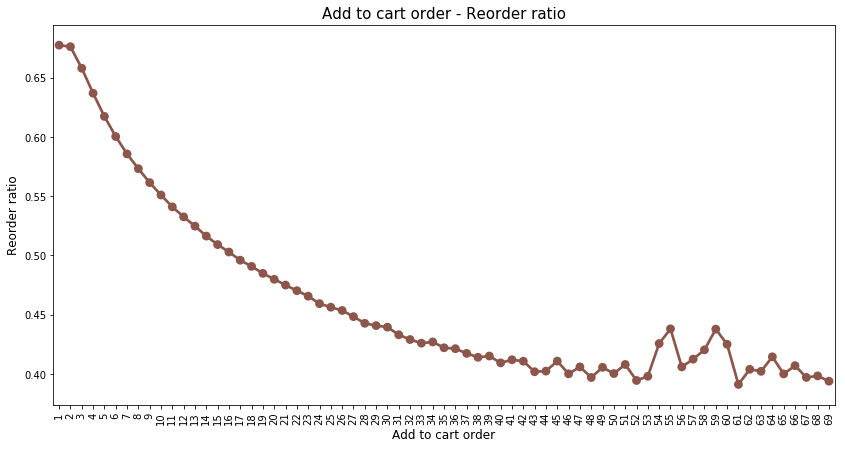

In [17]:
reorder_cart_order = df_order_products[['add_to_cart_order','reordered']].groupby('add_to_cart_order').mean().reset_index().rename(columns={'reordered':'reorder_ratio'})
reorder_cart_order = reorder_cart_order[reorder_cart_order['add_to_cart_order']<70]
plt.figure(figsize=(14,7))
sns.pointplot(reorder_cart_order['add_to_cart_order'], reorder_cart_order['reorder_ratio'], alpha=0.8, color=color[5])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Add to cart order', fontsize=12)
plt.title("Add to cart order - Reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

用户在购买时习惯先把重复购买的物品加入购物车
#### 不同时段购买的商品中回购商品所占比例

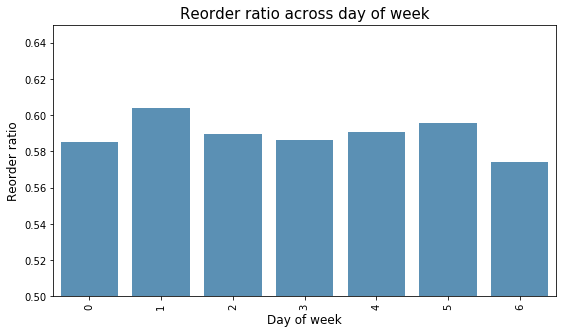

In [18]:
reorder = df_orders.merge(df_order_products[['order_id','reordered']],on="order_id")
reorder_dow = reorder.groupby("order_dow")["reordered"].mean().reset_index()
plt.figure(figsize=(9,5))
sns.barplot(reorder_dow['order_dow'], reorder_dow['reordered'], alpha=0.8, color=color[0])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.title("Reorder ratio across day of week", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.65)
plt.show()

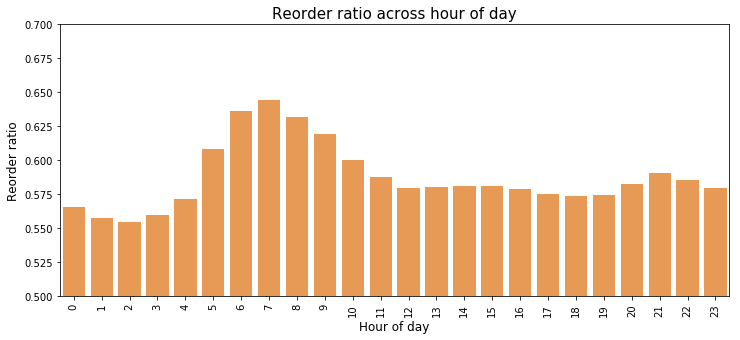

In [19]:
reorder_hod = reorder.groupby("order_hour_of_day")["reordered"].mean().reset_index()
plt.figure(figsize=(12,5))
sns.barplot(reorder_hod['order_hour_of_day'], reorder_hod['reordered'], alpha=0.8, color=color[1])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.title("Reorder ratio across hour of day", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

day of week这个因素差别不太明显，每天的不同购物时段在早晨6 7点有一个小高峰，考虑可能是早晨买蔬果等食材的保质期短，又是每天饭前要准备的，这个结果很合理。